In [ ]:
# Copyright 2019 Google LLC
# Copyright 2025 Anonymized Authors

# Licensed under the Apache License, Version 2.0 (the "License"); 
# you may not use this file except in compliance with the License. 
# You may obtain a copy of the License at
# https://www.apache.org/licenses/LICENSE-2.0
"""
We investigate the influence of using different groups of architectures as 
targets to sample the mutation indices from. We use averaged groups of the 
top 1, 10, 100, and 1000 models, selected first from the entire dataset, and 
then from the dataset after excluding the top 50%. 

Requirements: 

-This notebook requires that tensorflow and numpy be installed within the 
Python environment you are running this script in. 

"""
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import random 
import sys
from IPython.display import clear_output

import sys; sys.path.append('..')
from utils.nas_utils import load_nasbench, NASBenchConstants, init_pop, NASBench, SpecOneHot, random_spec
from utils.plotting import plot_all
from nasbench.api import ModelSpec

nasb = load_nasbench()


In [78]:
# this returns our split for entire dataset and lower ranked 50% (flop)
def hide_top(nasb, hide):
    """Splitting NAS-Bench-101 dataset with indicated hide parameter."""

    stats = []
    for key in nasb.computed_statistics:

        # only add matrixes of shape (NUM_VERTICES,NUM_VERTICES)
        if len(nasb.fixed_statistics[key]["module_operations"]) != NASBenchConstants.NUM_VERTICES:
            continue
        stats.append([key, 
                      nasb.computed_statistics[key][108][0]["final_test_accuracy"],
                      nasb.fixed_statistics[key]
                      ])

    sorted_list = sorted(stats, key=lambda x: x[1], reverse=False)
    cutoff_index = int(len(sorted_list) * (1-hide))

    flop = sorted_list[:cutoff_index]
    top = sorted_list[cutoff_index:]

    print(f"before: {len(sorted_list)}")
    print(f"top{int(hide*100)} : {len(top)}")
    print(f"flop{int(100*(1-hide))}: {len(flop)}")

    return top, flop

top, flop = hide_top(nasb, 0.5) # top is technically not the full dataset, but we just use a couple of the best 1000



before: 359082
top50 : 179541
flop50: 179541


In [79]:
def greedy_selection(parents):
    """Selects greedy n parent pairs"""
    p_size = len(parents)
    population = np.asarray([p[0] for p in parents])

    summed_population = []
    for p1 in range(p_size):
        for p2 in range(p_size):
            if p1 < p2: # only upper triangle
                sum = population[p1] + population[p2]
            else:
                sum = 0
            summed_population.append(sum)

    samples = np.argsort(summed_population)[-p_size:]
    row_indices, col_indices = np.meshgrid(np.arange(p_size),np.arange(p_size))
    mapping = np.reshape(np.stack([col_indices,row_indices],axis=-1), [-1,2])
    pairings = mapping[samples]

    paired_parents = []
    for i in range(len(pairings)):
        p1 = parents[pairings[i,0]]
        p2 = parents[pairings[i,1]]
        paired_parents.append((p1,p2))

    return paired_parents


# crossover with no fixed crossover point
def crossover(nasb, parents):
    """Performs vertical crossover on parent pairs, ensuring valid offspring."""
    
    def cross(p1, p2):
        if p1.original_matrix.shape != p2.original_matrix.shape:
            print("Shape mismatch")
            return p1

        for _ in range(5):
            i = random.randint(1, NASBenchConstants.NUM_VERTICES - 1)
            m = np.copy(p1.original_matrix)
            m[:i, :] = p2.original_matrix[:i, :]
            o = p1.original_ops[:i] + p2.original_ops[i:]
            new_spec = SpecOneHot(m, o)
            if nasb.is_valid(new_spec):
                return new_spec
        return p1

    return [cross(p[0][1], p[1][1]) for p in parents]

# this class holds the targets that are used to mutate the children
class Average():
    def __init__(self, nasb, best, psize = 32):
        super(Average, self).__init__()

        # define nasbench utils
        self.nasb = nasb
        self.psize = psize

        # array of some best architectures
        self.best = best
        self.probs1, self.probs0 = self.get_best_av()
        print(f"probabilities of setting a 1 for top{len(self.best)}")
        print(self.probs1)

        
    def get_best_av(self): 
        total = np.zeros(SpecOneHot.input_size)
        for ret in self.best:
            adj = ret[2]["module_adjacency"]
            ops = ret[2]["module_operations"]
            spec = SpecOneHot(adj,ops)
            total +=  spec.to_flat()
        ret = total/len(self.best)

        # av = (ret).float()       
        av = ret
        return av, 1.-av



    def prepare_inputs(self, population=None):
        inputs = [x.to_flat() for x in population]
        stacked = np.stack(inputs)  # Stack the inputs along a new axis (default axis=0)
        return stacked


    def mutate(self, population):
        mutation_inputs = self.prepare_inputs(population)
        children = []

        if len(population) < 32:
            print("dd")

        probs1 = self.probs1
        probs0 = self.probs0
        for i in range(self.psize):
            for k in range(100):
                mutated_spec = mutation_inputs[i,:].copy()

                mutation_index = np.random.choice(len(probs1), 1, p=probs1/ probs1.sum())[0]

                offset = 2
                if mutation_index >= SpecOneHot.flat_matrix:
                    offset = len(NASBenchConstants.ALLOWED_OPS)

                base = (mutation_index - (mutation_index%offset))
                remove = []
                for l in range(offset):
                    remove.append(base+l)
                mutated_spec[remove] = 0
                mutated_spec[mutation_index] = 1
                            
                
                # spec = SpecOneHot.spec_from_flat(mutated_spec)
                spec = SpecOneHot.spec_from_flat(mutation_inputs[i,:])
                if self.nasb.is_valid(spec):
                    children.append(spec)
                    break
                if k==99:
                    print("maximum reached. Default to using parent as child")
                    children.append(population[i])
        if len(children) < 32: 
            print("stop right here: " + str(i))
        return children


In [80]:
# this is for running our custom evolution algorithm 
def run_xevolution(
    nasbench: NASBench,
    avr = None,
    max_time_budget=5e6,
    p_size=50,
    ):
    """Run a single roll-out of evolution to a fixed time budget."""
    population, times, best_valids, best_tests = init_pop(nasbench, max_time_budget, p_size)
    while True:
        # generational approach: children replace old population
        selected_candidates = greedy_selection(population)  
        crossed_parents = crossover(nasbench, selected_candidates)
        children = avr.mutate(crossed_parents)
        population = []
        for child in children: 
            data = nasbench.query(child)
            time_spent, _ = nasbench.get_budget_counters()
            times.append(time_spent)
            population.append((data["validation_accuracy"], child))
            if data["validation_accuracy"] > best_valids[-1]:
                best_valids.append(data["validation_accuracy"])
                best_tests.append(data["test_accuracy"])
            else:
                best_valids.append(best_valids[-1])
                best_tests.append(best_tests[-1])

        if time_spent> max_time_budget:
            break

    return times, best_valids, best_tests


In [81]:
# print out results for table used in paper to show performances of top models
results = []
for part in [top, flop]:
    row = []
    for n in [1, 10, 100, 1000]:
        bestN = part[-n:]
        total = sum(b[1] for b in bestN)
        row.append(total / len(bestN))
    results.append(row)

# Generate the LaTeX table
latex_table = "\\begin{tabular}{|c|c|c|c|c|}\n\\hline\n & top 1 & top 10 & top 100 & top 1000 \\\\\n\\hline\n"
latex_table += f"\\text{{full dataset}} & {results[0][0]:.4f} & {results[0][1]:.4f} & {results[0][2]:.4f} & {results[0][3]:.4f} \\\\\n"
latex_table += "\\hline\n"
latex_table += f"\\text{{lower ranked}} & {results[1][0]:.4f} & {results[1][1]:.4f} & {results[1][2]:.4f} & {results[1][3]:.4f} \\\\\n"
latex_table += "\\hline\n\\end{tabular}"

print(latex_table)


\begin{tabular}{|c|c|c|c|c|}
\hline
 & top 1 & top 10 & top 100 & top 1000 \\
\hline
\text{full dataset} & 0.9466 & 0.9440 & 0.9418 & 0.9392 \\
\hline
\text{lower ranked} & 0.9055 & 0.9055 & 0.9055 & 0.9055 \\
\hline
\end{tabular}


In [82]:
# now lets define all average models that we want

# in the paper we have top1,10,100,1000 of respectively entire (top) and 
# lower ranked (flop)

models = {
    "avr1": 1,
    "avr10": 10,
    "avr100": 100,
    "avr1000": 1000,        
}

# Create dictionaries instead of lists
top_models = {key: Average(nasb, top[-count:], 32) for key, count in models.items()}
flop_models = {key: Average(nasb, flop[-count:], 32) for key, count in models.items()}



probabilities of setting a 1 for top1
[0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1.
 1. 0. 1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0.
 1. 0. 0. 1. 0. 0. 0. 1. 0.]
probabilities of setting a 1 for top10
[0.  1.  0.1 0.9 0.7 0.3 0.9 0.1 0.6 0.4 0.  1.  0.9 0.1 0.7 0.3 1.  0.
 0.4 0.6 0.9 0.1 0.3 0.7 0.8 0.2 0.7 0.3 1.  0.  0.1 0.9 0.9 0.1 1.  0.
 0.  1.  1.  0.  0.  1.  0.5 0.3 0.2 0.6 0.  0.4 0.8 0.  0.2 1.  0.  0.
 0.7 0.3 0. ]
probabilities of setting a 1 for top100
[0.   1.   0.41 0.59 0.67 0.33 0.78 0.22 0.53 0.47 0.12 0.88 0.53 0.47
 0.85 0.15 0.77 0.23 0.64 0.36 0.88 0.12 0.32 0.68 0.86 0.14 0.76 0.24
 0.96 0.04 0.05 0.95 0.93 0.07 1.   0.   0.   1.   1.   0.   0.   1.
 0.67 0.22 0.11 0.54 0.24 0.22 0.53 0.23 0.24 0.78 0.18 0.04 0.69 0.31
 0.  ]
probabilities of setting a 1 for top1000
[0.    1.    0.43  0.57  0.566 0.434 0.711 0.289 0.565 0.435 0.334 0.666
 0.462 0.538 0.835 0.165 0.842 0.158 0.739 0.261 0.751 0.249 0.395 0.605
 0

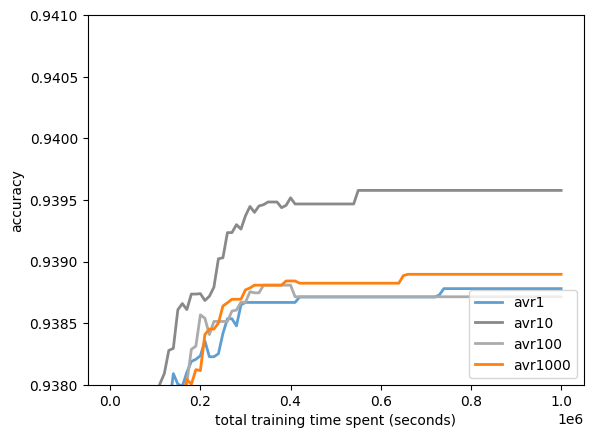

In [89]:
# exp1 is using all top models
exp1 = {
    "data": 
    {
        "avr1" : [[],"Blue"],
        "avr10" : [[],"Dark Gray"],
        "avr100" : [[],"Light Gray"],
        "avr1000" : [[],"Dark Orange"],

    },
    "config": 
    {
        "budget" : int(1e6),
        "limits" : (0.938, 0.941),
        "n" : 50,
        "print_every" : 2,
        "confidence_intervall" : False,
        "pvalue" : 0.05,
        "significant_areas": False,
        "dataset" : "test",
   }
}

# save barebone for later
exp2 = exp1.copy()

budget = exp1["config"]["budget"]
for run in range(exp1["config"]["n"]):
    for name,avr in top_models.items():
        nasb.reset_budget_counters()
        times, best_valid, best_test = run_xevolution(nasb, avr, budget, 32)
        exp1["data"][name][0].append((times, best_valid, best_test))

    if (run % exp1["config"]["print_every"] == 0):
        clear_output(wait=True)
        fig, ax = plt.subplots()
        plot_all(exp1, ax)
        plt.show()
        print('Running repeat %d' % (run + 1))

clear_output(wait=True)
fig, ax = plt.subplots()
plot_all(exp1, ax)
plt.show()

In [ ]:
# exp2 is using all flop models
budget = exp2["config"]["budget"]
for run in range(exp2["config"]["n"]):
    for name,avr in flop_models.items():
        nasb.reset_budget_counters()
        times, best_valid, best_test = run_xevolution(nasb, avr, budget, 32)
        exp2["data"][name][0].append((times, best_valid, best_test))

    if (run % exp2["config"]["print_every"] == 0):
        clear_output(wait=True)
        fig, ax = plt.subplots()
        plot_all(exp1, ax)
        plt.show()
        print('Running repeat %d' % (run + 1))

clear_output(wait=True)
fig, ax = plt.subplots()
plot_all(exp2, ax)
plt.show()

In [63]:
# save results to folder
! this could overwrite existing files

f1 = os.path.join("..","..","models", "em3", "av1_50_1e6.json")
f10 = os.path.join("..","..","models", "em3", "av10_50_1e6.json")
f100 = os.path.join("..","..","models", "em3", "av100_50_1e6.json")
f1000 = os.path.join("..","..","models", "em3", "av1000_50_1e6.json")

f1 = os.path.join("..","..","models", "em3", "av1_1e6.json")
f10 = os.path.join("..","..","models", "em3", "av10_1e6.json")
f100 = os.path.join("..","..","models", "em3", "av100_1e6.json")
f1000 = os.path.join("..","..","models", "em3", "av1000_1e6.json")

with open(f1, 'w') as file:
    json.dump(exp1["data"]["avr1"][0], file)

with open(f10, 'w') as file:
    json.dump(exp1["data"]["avr10"][0], file)

with open(f100, 'w') as file:
    json.dump(exp1["data"]["avr100"][0], file)

with open(f1000, 'w') as file:
    json.dump(exp1["data"]["avr1000"][0], file)